## NumEx: Discovering Numeric Joinable Tables with Semantically Related Columns
NumEx is a join discovery tool for numeric tables that assesses the likelihood that attributes of join candidates have semantic relationships with the input table.

NumEx works roughly as follows:

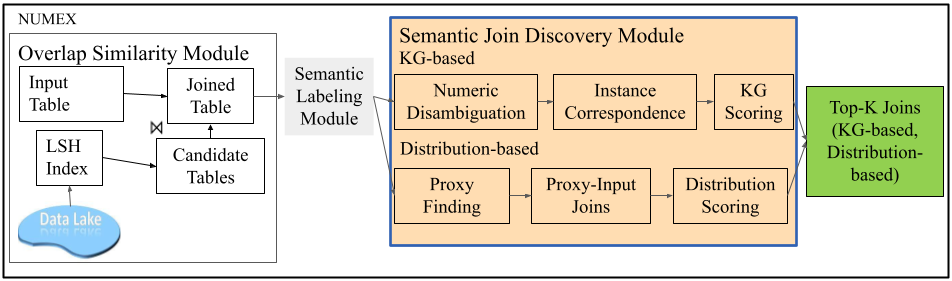

In [1]:
from IPython.display import Image
Image(filename='numexarch.png') 

## NumEx Use Case Selection
Welcome to the NumEx Demo! Our supported use cases are shown below. Pick the dataset whose use case you are interested in. NumEx will take this dataset as input and return the top-k strongly-semantic joins, both according to a knowledge graph (KG), and according to numeric distributions.

In [2]:
from fullmethod import display_usecases

In [3]:
display_usecases()

,Description,Dataset Prefix
0,What factors contribute to bus revenues?,demo_lake/busridertbl.csv
1,What factors contribute to soccer players' success?,demo_lake/soccerplayertbl.csv
2,What factors affect hospital congestion?,demo_lake/hospitaltbl.csv
3,What factors affect bank revenues?,demo_lake/banktbl.csv
4,Does where a politician was educated affect their popularity?,demo_lake/politiciantbl.csv
5,What other factors help me predict churn for banking customers?,demo_lake/Churn_Modelling.csv
6,What other factors would help me predict audit risk?,demo_lake/audit_risk.csv
7,What factors can help me determine if a client subscribe a term deposit?,demo_lake/bank_full.csv
8,What factors help in predicting credit card default?,demo_lake/default.csv
9,How can I segment bank customers?,demo_lake/german_credit.csv


## Finding Minhash LSH-based Join Candidates
Given your chosen input dataset from above, NumEx will use its prebuilt Minhash LSH index to find candidates over a data lake.

In [3]:
from numex_apis import show_lshjoins

In [4]:
show_lshjoins('demo_lake/busridertbl.csv')

,Output Table,Output Table Join Key,Input Table Join Key
0,demo_lake/politicianjoin.csv,Unnamed: 0,Unnamed: 0
1,demo_lake/soccertbl.csv,Unnamed: 0.1,Unnamed: 0
2,demo_lake/Team_Attributes.csv,chanceCreationPassing,Unnamed: 0
3,demo_lake/Team_Attributes.csv,buildUpPlayPassing,Unnamed: 0
4,demo_lake/soccertbl.csv,Unnamed: 0,Unnamed: 0
...,...,...,...
56,demo_lake/busridertbl.csv,dbo:BusCompany,dbo:BusCompany
57,demo_lake/busridertbl.csv,<http://dbpedia.org/property/annualRidership>,<http://dbpedia.org/property/annualRidership>
58,demo_lake/busridertbl.csv,<http://dbpedia.org/ontology/numberOfLines>,<http://dbpedia.org/ontology/numberOfLines>
59,demo_lake/busridertbl.csv,dbo:regionServed,dbo:regionServed


Above, you can see the candidate table names and join keys in the 'Output Table' column and 'Output Table Join Key' columns respectively. You can see the corresponding join key of the input table in the 'Input Table Join Key' column as well, e.g., the table 'demo_lake/Team_Attributes.csv' joins on column 'buildUpPlayPassing' with the input table on column 'Unnamed: 0'.

## Semantic Labeling
NumEx chooses the most likely semantic label (DBpedia class property label) for each column of every candidate table (the likelihood is called a 'membership probability'). Semantic labels and likelihoods for an example table are shown below.

In [6]:
from numex_apis import show_semantic_labels
show_semantic_labels('demo_lake/busridertbl.csv')

,Column Name,Best Semantic Label,Membership Probability
0,<http://dbpedia.org/property/annualRidership>,"(['dbo:BusCompany'], '<http://dbpedia.org/property/annualRidership>')",0.99999
1,<http://dbpedia.org/ontology/numberOfLines>,"(['dbo:BusCompany'], '<http://dbpedia.org/ontology/numberOfLines>')",0.99999


Then, for each candidate table, NumEx computes the entropies of the semantic label likelihoods for each column, and averages them across candidate table columns. If this average entropy is below some chosen entropy threshold, NumEx uses the KG-based approach. Otherwise, NumEx uses the Distribution-based approach.

In [7]:
from numex_apis import avg_member_entropy

avg_member_entropy('demo_lake/busridertbl.csv', 
                   'demo_lake/busriderjoin.csv')

,Average Entropy,Recommended Method,Entropy Threshold
0,0.328888,KG-based,0.5


## KG-based Approach: Numeric Disambiguation
If NumEx chooses the KG-based approach for a candidate table, then for each row in the join, NumEx will use the semantic labels and cell values to disambiguate the row to at least two real-world entities, (at least one per table involved in the join). In the example below, the first row of the join between tables busridertbl.csv and busriderjoin.csv is disambiguated as bus company 'Shuttle-UM', and location 'Montgomery County, Maryland'. 

In [8]:
import pandas as pd
from numex_apis import disambiguate_onerow

indf = pd.read_csv('demo_lake/busridertbl.csv')
outdf = pd.read_csv('demo_lake/busriderjoin.csv')
joindf = indf.merge(outdf, left_on='dbo:regionServed', right_on='dbo:regionServed')
row0 = joindf.to_dict(orient='records')[0]

disambiguate_onerow('demo_lake/busridertbl.csv', 'demo_lake/busriderjoin.csv', row0)

({('dbo:BusCompany',): ['http://dbpedia.org/resource/Shuttle–UM']},
 {(): ['http://dbpedia.org/resource/Montgomery_County,_Maryland']})

## KG-based Approach: Instance Correspondence
Once NumEx has found at least one pair of real-world entities (instances) for each row of the join, it will find relationships for each pair of entities. For example, between entities 'Shuttle-UM' and 'Montgomery County, Maryland', NumEx finds two possible relationships: 'regionServed', and 'serviceArea'.

In [9]:
from numex_apis import find_relationships

find_relationships({('dbo:BusCompany',): ['http://dbpedia.org/resource/Shuttle–UM']},
                  {(): ['http://dbpedia.org/resource/Montgomery_County,_Maryland']})

[(('dbo:BusCompany',), 'http://dbpedia.org/ontology/regionServed', ()),
 (('dbo:BusCompany',), 'http://dbpedia.org/property/serviceArea', ())]

## KG-based Approach: KG Scoring
NumEx scores the join based on the highest proportion of records in the join with the same relationship. In this case, the 'serviceArea' and 'regionServed' relationships were found in 184 out of 202 records, so the KG score is 184 / 202 = 0.91, roughly.

In [10]:
from numex_apis import find_kgstrength
find_kgstrength('demo_lake/busridertbl.csv', 'demo_lake/busriderjoin.csv')

(0.91,
 {(('dbo:BusCompany',), 'http://dbpedia.org/property/serviceArea', ()): 184,
  (('dbo:BusCompany',), 'http://dbpedia.org/ontology/regionServed', ()): 184},
 202)

## KG-based Approach: Example Result
We provide the APIs above to run various parts of NumEx's KG-based approach. Given the input table and a candidate, one can run the full KG-based approach using the below API. This visualizes the entities NumEx finds in the green column. The join keys are shown in yellow.

In [5]:
from numex_apis import show_kgmatch
show_kgmatch('demo_lake/busridertbl.csv', 'demo_lake/busriderjoin.csv')

,Unnamed: 0,BusCompany,annualRidership,numberOfLines,regionServed_id
0,0,Shuttle–UM,2956600.00,31,2
1,1,Razorback_Transit,1989087.00,19,3
2,2,El_Metro_Transit,4300000.00,24,4
3,3,Pace_(transit),28392400.00,218,5
4,4,Roaring_Fork_Transportation_Authority,5470000.00,3,1
,Unnamed: 0,regionServed,areaTotal,percentageOfAreaWater,regionServed_id
0,0,"Montgomery_County,_Maryland",1313.12,0.03,2
1,1,"Washington_County,_Arkansas",2464.94,0.60,3
2,2,"Webb_County,_Texas",8741.21,0.40,4
3,3,"Will_County,_Illinois",2198.90,0.01,5


## KG-based Approach Full Pipeline: Finding the Top-k
Given an input table and number of join candidates to return, k, NumEx will return up to k joins with the highest scores. Below, we see that given input table 'demo_lake/busridertbl.csv' and k = 3, NumEx finds only one table 'demo_lake/busriderjoin.csv' with score 0.91.

In [13]:
from numex_apis import show_topk_kgmatches
show_topk_kgmatches('demo_lake/busridertbl.csv', 3)

,Rank,Table Name,Join Key,Score,Best Relationship
0,1,demo_l...,dbo:re...,0.91,http:/...


## Distribution-based Approach: Proxy Finding
Given an input table 'demo_lake/ETF prices.csv', NumEx first finds a proxy table that is most similar to the input based on numeric types and distributions of column values. The distributions are described using numeric features (e.g., number of unique values and their frequencies), and NumEx finds the normalized difference between numeric features of the input table, and those of the join candidate. In this case, the join candidate is 'demo_lake/IndexProcessed.csv', and the normalized difference is 0.112529.

In [14]:
from numex_apis import find_proxy_table
find_proxy_table('demo_lake/ETF prices.csv')

,Proxy Table,Normalized Numeric Feature Difference
0,demo_l...,0.112529


## Distribution-based Approach: Proxy-Input Joins
Given the proxy table, NumEx then finds Minhash LSH-based join candidates. Similar to the above, we show the join candidate ('Output table'), its join key, ('Output Table Join Key'), and the input table join key for the candidate ('Input Table Join Key').

In [15]:
show_lshjoins('demo_lake/indexProcessed.csv')

,Output Table,Output Table Join Key,Input Table Join Key
0,demo_l...,Index,Index
1,demo_l...,price_...,Date
2,demo_l...,price_...,Date
3,demo_l...,Date,Date
4,demo_l...,price_...,Date
5,demo_l...,Open,Open
6,demo_l...,Adj Close,High
7,demo_l...,Close,High
8,demo_l...,High,High
9,demo_l...,Low,Low


## Distribution-based Approach: Distribution Scoring
NumEx scores the join based on the join cardinality, which is the number of records in the join divided by the product of the numbers of records in both the input and candidate tables. For example, the score of the join between 'demo_lake/ETF prices.csv' and 'demo_lake/MutualFund prices - A-E.csv' is roughly 0.0001, as shown below.

In [16]:
from numex_apis import find_diststrength
find_diststrength('demo_lake/ETF prices.csv', 'demo_lake/MutualFund prices - A-E.csv')

0.00010831546535126091

## Distribution-based Approach: Example Result
We provide the APIs above to run various parts of NumEx's distribution-based approach. Given the input table and a candidate, one can run the full KG-based approach using the below API. This visualizes the proxy table and join table NumEx finds. The join keys are shown in yellow.

In [6]:
from numex_apis import show_distmatch
show_distmatch('demo_lake/ETF prices.csv', 'demo_lake/MutualFund prices - A-E.csv')

Input Table: demo_lake/ETF prices.csv 
 
 
   
 fund_symbol 
 price_date 
 open 
 high 
 low 
 close 
 adj_close 
 volume 
 
 
 
 
 0 
 AAA 
 2020-09-09 
 25.10 
 25.12 
 25.07 
 25.07 
 24.85 
 17300 
 
 
 1 
 AAA 
 2020-09-10 
 25.06 
 25.07 
 25.05 
 25.07 
 24.85 
 23500 
 
 
 2 
 AAA 
 2020-09-11 
 25.04 
 25.05 
 25.02 
 25.03 
 24.81 
 33400 
 
 
 3 
 AAA 
 2020-09-14 
 25.01 
 25.06 
 25.01 
 25.02 
 24.80 
 13100 
 
 
 4 
 AAA 
 2020-09-15 
 25.02 
 25.03 
 25.01 
 25.01 
 24.79 
 12100 
 
 
 

 
 Non-KG Proxy Table: demo_lake/indexProcessed.csv 
 
 
   
 Index 
 Date 
 Open 
 High 
 Low 
 Close 
 Adj Close 
 Volume 
 CloseUSD 
 
 
 
 
 0 
 HSI 
 1986-12-31 
 2568.30 
 2568.30 
 2568.30 
 2568.30 
 2568.30 
 0.00 
 333.88 
 
 
 1 
 HSI 
 1987-01-02 
 2540.10 
 2540.10 
 2540.10 
 2540.10 
 2540.10 
 0.00 
 330.21 
 
 
 2 
 HSI 
 1987-01-05 
 2552.40 
 2552.40 
 2552.40 
 2552.40 
 2552.40 
 0.00 
 331.81 
 
 
 3 
 HSI 
 1987-01-06 
 2583.90 
 2583.90 
 2583.90 
 2583.90 
 2583.90 
 0.00 
 335.91 
 
 
 4 
 HSI 
 1987-01-07 
 2607.10 
 2607.10 
 2607.10 
 2607.10 
 2607.10 
 0.00 
 338.92 
 
 
 

 
 Non-KG Join Table: demo_lake/MutualFund prices - A-E.csv
Relationship Strength: 0.0001083 
 
 
   
 fund_symbol 
 price_date 
 nav_per_share 
 
 
 
 
 0 
 AAAAX 
 2007-07-31 
 10.02 
 
 
 1 
 AAAAX 
 2007-08-01 
 9.98 
 
 
 2 
 AAAAX 
 2007-08-02 
 10.01 
 
 
 3 
 AAAAX 
 2007-08-03 
 9.90 
 
 
 4 
 AAAAX 
 2007-08-06 
 9.93

## Distribution-based Approach Full Pipeline: Finding the Top-k
Given an input table and number of join candidates to return, k, NumEx will return up to k joins with the highest scores. Below, we see that given input table 'demo_lake/ETF prices.csv' and k = 3, NumEx finds two tables, 'demo_lake/MutualFund prices - A-E.csv' and 'demo_lake/MutualFund prices - F-K.csv'  with scores 0.000108 and 0.000107 respectively.

In [40]:
from numex_apis import show_topk_distmatches
show_topk_distmatches('demo_lake/ETF prices.csv', 3)

,Input Table,Proxy Table,Output Table,Distribution-based Strength
0,demo_lake/ETF prices.csv,demo_lake/indexProcessed.csv,demo_lake/MutualFund prices - A-E.csv,0.000108
1,demo_lake/ETF prices.csv,demo_lake/indexProcessed.csv,demo_lake/MutualFund prices - F-K.csv,0.000107
